<span style="color:red">
Note: This should not be merged into python-neo, but helps me figure out how to write axonarawio.py. I will add it to the axonarawio branch for now, but should delete it before a PR!
</span>.


# Read axona .bin file

We will go through the steps for reading in Axona dacqUSB system .bin data in continuous format.
The goal is to later implement this in axonarawio.py.

Here is the relevant information from the dacqUSB manual (found here: http://space-memory-navigation.org/DacqUSBFileFormats.pdf):


### Header
The header consists of:
* 4 bytes ID (will be "ADU1", unless the tracker position record is populated with valid data,
in which case it will be "ADU2")
* 4 bytes packet number
* 2 bytes digital inputs
* 2 bytes sync inputs
* 20 bytes tracker position record (only valid data if packet ID is "ADU2") -- same format as
standard .pos file position records.

### Data
Then there are three samples x 64 channels x 16-bits (= 384 bytes), followed by 16
dummy bytes at the end to make up the total packet length of 432. The samples order is
given below. Each sample is two bytes long, in 2's complement.
The data are stored at 48 kHz, so you should have 16000 packets of 432 bytes per second
of recording. Yes, this is very inefficient because you don't have anywhere near 64
channels so it is mostly wasted space; this will be improved in a future version update.
The main complication is that the order of the channels in the data file is not something
nice like 1,2,3, ... Instead, there is a remapping function:
<p>
remap_channels : array [1..64] of word = (
 32, 33, 34, 35, 36, 37, 38, 39,
 0, 1, 2, 3, 4, 5, 6, 7,
 40, 41, 42, 43, 44, 45, 46, 47,
 8, 9, 10, 11, 12, 13, 14, 15,
 48, 49, 50, 51, 52, 53, 54, 55,
 16, 17, 18, 19, 20, 21, 22, 23,
 56, 57, 58, 59, 60, 61, 62, 63,
 24, 25, 26, 27, 28, 29, 30, 31 ); 
</p>

For instance, if you want to find the data for channel 7, you look at remap_channels[7],
which is 38. So, in the 432-byte packet, you ignore the 32 byte header, and the data for
channel 7 will be at:
* bytes 32(header)+(38*2), and 32+(38*2+1) (first sample low and high bytes)
* bytes 32(header)+128(first samples, 64 ch x 2 bytes)+(38*2), and 32+128+(38*2+1) (2nd sample) 
* bytes 32+128+128+(38*2), and 32+128+128+(38*2+1) (third sample) and so on.

### Trailer
Finally, the trailer consists of 16 bytes:
2 bytes contain a record of digital output values
2 bytes contain stimulator status
10 bytes of zeroes (reserved for future use)
2 bytes contain the ASCII keycode if a key was pressed during the time the packet was
active. 

In [1]:
# Imports

import os
import sys
import mmap  # python library for memory mapping
import numpy as np  # contains np.memmap for memory mapping (used in python-neo)
import contextlib  # useful for managing contexts
import datetime
import re

In [2]:
# Set directory and filename

dir_name = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = '20201004_Raw'
suffix = '.bin'

bin_file = os.path.join(dir_name, base_filename + suffix)

print(bin_file)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin


Create a small example file (400 ms) to upload on https://gin.g-node.org/NeuralEnsemble/ephy_testing_data

In [3]:
with open(bin_file, 'rb') as f:
    content = f.read(int(48000*432*0.4))
    
print(sys.getsizeof(content))

8294433


In [4]:
example_filename = 'axona_raw'
example_bin_file = os.path.join(dir_name, example_filename + suffix)
f = open(example_bin_file, 'w+b')
f.write(content)

8294400

In [5]:
# re-read small example dataset 

with open(example_bin_file, 'rb') as f:
    content2 = f.read()
    
print(sys.getsizeof(content2))

8294433


In [6]:
assert content == content2

In [7]:
print(content2[0:100])

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06'


In [8]:
# We will also need the .set file later for info about the recording setup.

suffix = '.set'

set_file = os.path.join(dir_name, base_filename + suffix)

print(set_file)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.set


In [9]:
# Read the first 432 bytes and look at them

with open(bin_file, 'rb') as f:
    content = f.read(432)

print(content)

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06\xf0(|%\n\xed,1\xbcJ\xf0(\xe6\xfe"\x03f\xf9\xd8\x03\x10\x140\x1d\x02\x1a\xb2\x15\xa8A\x10\x14\x86\t\xe0\xf7\x1e\x07\xde\x06x\xf3\x0e\xf4\xa2\xa8\xfc\xca\xce\xedx\xf3j\x11\xa2\x16\x16\x04\x94\xe82\xff\xfc\xe8:\xb1>\x03v\xf82\xff\xea\xdb\xc8\xe7Z\xf0\x9c\xf0\xd8\xfc\x1a\xd7\x0c\xe6\x10\xe9\x1e\xd1\xd8\xfc\xba\xd5\xb6\xe3\x90\xe7P\xe0\x90\xe7j\xe9v\xff\xae\xe9p\xde\x90\xe7l\x12F\x02\x84\x0f\xe4\x11\xce\x06\x1a\xff\xe2\xf0D\xff\xbc\x14\xce\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

Note the substantial amount of wasted space (always assuming 64 channels)

In [10]:
# Read the first 432 * 2 bytes and look at them

with open(bin_file, 'rb') as f:
    content = f.read(432 * 2)

print(content)

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06\xf0(|%\n\xed,1\xbcJ\xf0(\xe6\xfe"\x03f\xf9\xd8\x03\x10\x140\x1d\x02\x1a\xb2\x15\xa8A\x10\x14\x86\t\xe0\xf7\x1e\x07\xde\x06x\xf3\x0e\xf4\xa2\xa8\xfc\xca\xce\xedx\xf3j\x11\xa2\x16\x16\x04\x94\xe82\xff\xfc\xe8:\xb1>\x03v\xf82\xff\xea\xdb\xc8\xe7Z\xf0\x9c\xf0\xd8\xfc\x1a\xd7\x0c\xe6\x10\xe9\x1e\xd1\xd8\xfc\xba\xd5\xb6\xe3\x90\xe7P\xe0\x90\xe7j\xe9v\xff\xae\xe9p\xde\x90\xe7l\x12F\x02\x84\x0f\xe4\x11\xce\x06\x1a\xff\xe2\xf0D\xff\xbc\x14\xce\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

At a glance it seems sensible to use f.read() 432 byte snippet by 432 byte snippet since there is no global header or footer. 
Note that the pointer moves with every call to f.read(), if I want to reset it to the beginning I could use f.seek(0)

In [11]:
# How many 432 byte packets does this data contain (<=> num. samples / 3)?

bytes_packet = 432

num_packets = int(os.path.getsize(bin_file)/bytes_packet)
print(num_packets)

9600100


In [12]:
# Windows tells me the .bin file is 4147243200  bytes

print('Bytes according to mmap_obj:', num_packets * bytes_packet)
print('Bytes according to Windows OS:', 4147243200)

assert(num_packets * bytes_packet == 4147243200)

Bytes according to mmap_obj: 4147243200
Bytes according to Windows OS: 4147243200


In [13]:
# Try with np.memmap instead (used a lot in python-neo)

global_header_size = 0
raw_data = np.memmap(bin_file, dtype='int16', mode='r', offset=global_header_size)

print('Size of raw_data:', len(raw_data))
print('Peak at raw_data:', raw_data[16:26])
print('Type of raw_data:', type(raw_data))

Size of raw_data: 2073621600
Peak at raw_data: [ -4384  -6024  -4552 -13192  -7572  -5500    798   2378   1886  -7572]
Type of raw_data: <class 'numpy.memmap'>


In [14]:
# Get data with code snippet from BinConverter, using mmap library:
# https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/readBin.py

# 1second = 48000 samples
# 1packet = 3 samples
num_test_samples = 48000 // 3 #num_packets  # read only 1s for testing purposes

bytes_packet = 432
bytes_data = 384
bytes_head = 32
bytes_tail = 16

with open(bin_file, 'rb') as f:

    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as mmap_obj:
        num_packets = int(len(mmap_obj)/bytes_packet)

        data = np.ndarray(shape=(num_test_samples,), 
                          dtype=(np.int16, (bytes_data//2)),  # replace num_test_samples with num_packets
                          buffer=mmap_obj[0:bytes_packet*num_test_samples],  # ultimately read all
                          offset=bytes_head, 
                          strides=(bytes_packet,)).reshape((-1, 1)).flatten()

In [15]:
def get_active_tetrode(set_filename):
    """in the .set files it will say collectMask_X Y for each tetrode number to tell you if
    it is active or not. T1 = ch1-ch4, T2 = ch5-ch8, etc."""
    active_tetrode = []
    active_tetrode_str = 'collectMask_'

    with open(set_filename, encoding='cp1252') as f:
        for line in f:

            # collectMask_X Y, where x is the tetrode number, and Y is eitehr on or off (1 or 0)
            if active_tetrode_str in line:
                tetrode_str, tetrode_status = line.split(' ')
                if int(tetrode_status) == 1:
                    # then the tetrode is saved
                    tetrode_str.find('_')
                    tet_number = int(tetrode_str[tetrode_str.find('_') + 1:])
                    active_tetrode.append(tet_number)

    return active_tetrode

In [16]:
def get_channel_from_tetrode(tetrode):
    """This function will take the tetrode number and return the Axona channel numbers
    i.e. Tetrode 1 = Ch1 -Ch4, Tetrode 2 = Ch5-Ch8, etc"""
    tetrode = int(tetrode)  # just in case the user gave a string as the tetrode

    return np.arange(1, 5) + 4 * (tetrode - 1)

In [17]:
active_tetrode_set = get_active_tetrode(set_file)
get_channel_from_tetrode(2)

array([5, 6, 7, 8])

In [18]:
def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)

    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)

    # return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)

In [19]:
def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""

    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5,
                               6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11,
                               12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17,
                               18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63,
                               24, 25, 26, 27, 28, 29, 30, 31])

    return remap_channels[chan_num - 1]

In [20]:
def samples_to_array(A, channels=[]):
    """This will take data matrix A, and convert it into a numpy array, there are three samples of
    64 channels in this matrix, however their channels do need to be re-mapped"""

    if channels == []:
        channels = np.arange(64) + 1
    else:
        channels = np.asarray(channels)

    A = np.asarray(A)

    sample_num = int(len(A) / 64)  # get the sample numbers

    sample_array = np.zeros((len(channels), sample_num))  # creating a 64x3 array of zeros (64 channels, 3 samples)

    for i, channel in enumerate(channels):
        sample_array[i, :] = A[get_sample_indices(channel, sample_num)]

    return sample_array

In [21]:
arr = samples_to_array(data, channels = [])

In [22]:
arr.shape

(64, 48000)

In [23]:
import matplotlib.pyplot as plt

def plot_data_snippet(data, start_idx=0, end_idx=None, Fs=48000, Nch=16):
    """Plot a data snippet from a Ch x samples array given a start index and
    end index. If Fs is supplied the x-axis is in seconds."""
    
    if end_idx is None:
        end_idx = len(data)
    
    plt.figure(figsize=(16,8))

    x = np.linspace(0, (end_idx-start_idx)/Fs, end_idx-start_idx)

    for irow in range(0, Nch):
        plt.plot(x.T, 80000*irow+data[irow,start_idx:end_idx], label='Ch'+str(irow))

    plt.xlabel("seconds", fontsize=20)
    plt.ylabel("channels", fontsize=20)
    plt.title("Example snippet of LFP data", fontsize=20)
    plt.show()

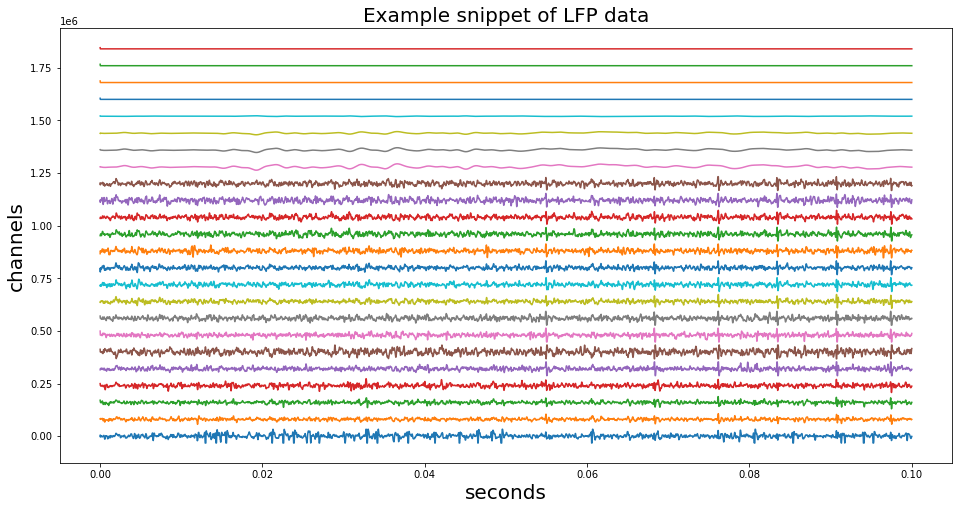

In [24]:
plot_data_snippet(arr, start_idx=0, end_idx=4800, Fs=48000, Nch = 24)

Why is there activity in channels 17-19 (just above the "normal" looking signals)?!

Should we use np.memmap and extract the data of interest in other functions of python-neo (e.g. in `_get_analogsignal_chunk`), or do we extract the array of data right away in `_parse_header`?

# Implement AxonaRawIO (step by step)

In [25]:
# Have a look at the .set file 
# Encoding is cp1252, even though it's supposed to be ascii

with open(set_file, 'r', encoding='cp1252') as f:
    rec_info = f.read()

print(rec_info[0:200])

trial_date Sunday, 4 Oct 2020
trial_time 11:07:07
experimenter Abid
comments 
duration 600.00625
sw_version 1.2.2.16
ADC_fullscale_mv 1500
tracker_version 0
stim_version 1
audio_version 0
gain_ch_0 10


In [26]:
from neo.rawio.baserawio import (_signal_channel_dtype, _spike_channel_dtype, _event_channel_dtype)

Read date and time of recording into datetime object

In [27]:
with open(set_file, 'r', encoding='cp1252') as f:
    for line in f:
        if line.startswith('trial_date'):
            date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
        if line.startswith('trial_time'):
            time_string = line[len('trial_time')+1::].replace('\n', '')

In [28]:
rec_datetime = datetime.datetime.strptime(date_string + ', ' + time_string, "%d %b %Y, %H:%M:%S")
rec_datetime

datetime.datetime(2020, 10, 4, 11, 7, 7)

In [29]:
# The first few entries of header are straightforward,
# since we do not have separate blocks or segments (the recording is continuous)

header = {}
header['nb_block'] = 1
header['nb_segment'] = [1]

In [30]:
def get_channel_gain(set_file):
    """ Read gain for each channel from .set file and return in list of integers """

    gain_list = []

    with open(set_file, encoding='cp1252') as f:
        for line in f:
            if line.startswith('gain_ch'):
                gain_list.append(int(re.findall(r'\d*', line.split(' ')[1])[0]))
                
    return gain_list

In [31]:
# Extract channel names and IDs
# For channel names we will use the dacq2 nomenclature (1a, 1b, 1c, 1d, 2a, 2b, ...), where numbers are tetrodes. 
# For IDs we will use 1, 2, 3, 4, 5, 6, ...
# Also note that 1, 2, 3, ... are NOT remapped yet (we still need to do that separately).

active_tetrode_set = get_active_tetrode(set_file)
num_active_tetrode = len(active_tetrode_set)

elec_per_tetrode = 4
letters = ['a', 'b', 'c', 'd']
sr = 48000
dtype = 'int16'
units = 'uV'
gain_list = get_channel_gain(set_file)
offset = 0  # What is the offset? 

sig_channels = []
for itetr in range(num_active_tetrode):
    
    for ielec in range(elec_per_tetrode):
        
        cntr = (itetr*elec_per_tetrode) + ielec
        ch_name = '{}{}'.format(itetr, letters[ielec])
        chan_id = cntr + 1
        gain = gain_list[cntr]
                
        # group_id isonly for special cases when channel have diferents
        # sampling rate for instance. See TdtIO for that.
        # Here this is the general case :all channel have the same characteritics
        group_id = 0
        sig_channels.append((ch_name, chan_id, sr, dtype, units, gain, offset, group_id))
        
sig_channels = np.array(sig_channels, dtype=_signal_channel_dtype)    

In [32]:
sig_channels

array([('0a', '1', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('0b', '2', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('0c', '3', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('0d', '4', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('1a', '5', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('1b', '6', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('1c', '7', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('1d', '8', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('2a', '9', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('2b', '10', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('2c', '11', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('2d', '12', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('3a', '13', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('3b', '14', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('3c', '15', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('3d', '16', 48000., 'int16', 'uV', 15000., 0., '0')],
      dtype=[('name', '<U64'), (

## Try axonarawio.py

In [33]:
from neo.rawio.baserawio import (_signal_channel_dtype, _spike_channel_dtype,
                                 _event_channel_dtype)
import numpy as np
import os
import mmap
import re
import contextlib
import datetime

In [34]:
# Set directory and filename

dir_name = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = '20201004_Raw'
suffix = '.bin'

bin_file = os.path.join(dir_name, base_filename + suffix)

print(bin_file)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin


In [35]:
import neo.rawio

r = neo.rawio.AxonaRawIO(filename=os.path.join(dir_name, base_filename))
r.parse_header()
print(r)

AxonaRawIO: ../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw
nb_block: 1
nb_segment:  [1]
signal_streams: [stream 0 (chans: 16)]
signal_channels: [0a, 0b, 0c, 0d ... 3a , 3b , 3c , 3d]
spike_channels: [unit0, unit1, unit2]
event_channels: [Some events, Some epochs]



In [36]:
r._raw_signals

memmap([17473, 12629,  1165, ...,   452,     0,     0], dtype=int16)

In [37]:
# Can I read the signal from the axonarawio?

raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=0, i_stop=48000, stream_index=0, channel_indexes=None)

print(type(raw_sigs))
print(raw_sigs.shape)
raw_sigs

<class 'numpy.ndarray'>
(16, 48000)


array([[ 3682., -3870.,     0., ...,  3890.,  -136., -4538.],
       [ 1714.,  -188.,     0., ...,  1306.,  -736., -3426.],
       [10480.,  5308.,     0., ..., -4060., -5640., -7398.],
       ...,
       [-5500.,  -206.,     0., ...,  5472.,  3824.,  1852.],
       [  798., -9238.,     0., ...,  8896.,  4986.,  3392.],
       [ 2378., -6200.,     0., ...,  4380.,  1014.,  -776.]])

In [38]:
arr

array([[ 3682., -3870.,     0., ...,  3890.,  -136., -4538.],
       [ 1714.,  -188.,     0., ...,  1306.,  -736., -3426.],
       [10480.,  5308.,     0., ..., -4060., -5640., -7398.],
       ...,
       [ 5406.,  4580.,     0., ...,     0.,     0.,     0.],
       [-4102.,  1742.,     0., ...,     0.,     0.,     0.],
       [ 3574.,  -230.,     0., ...,     0.,     0.,     0.]])

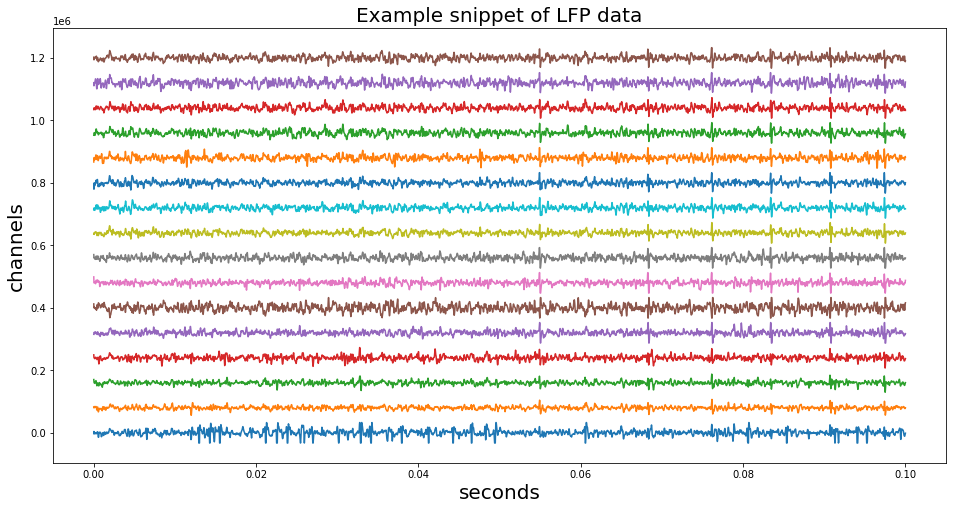

In [39]:
plot_data_snippet(raw_sigs, start_idx=0, end_idx=4800, Fs=48000, Nch=16)

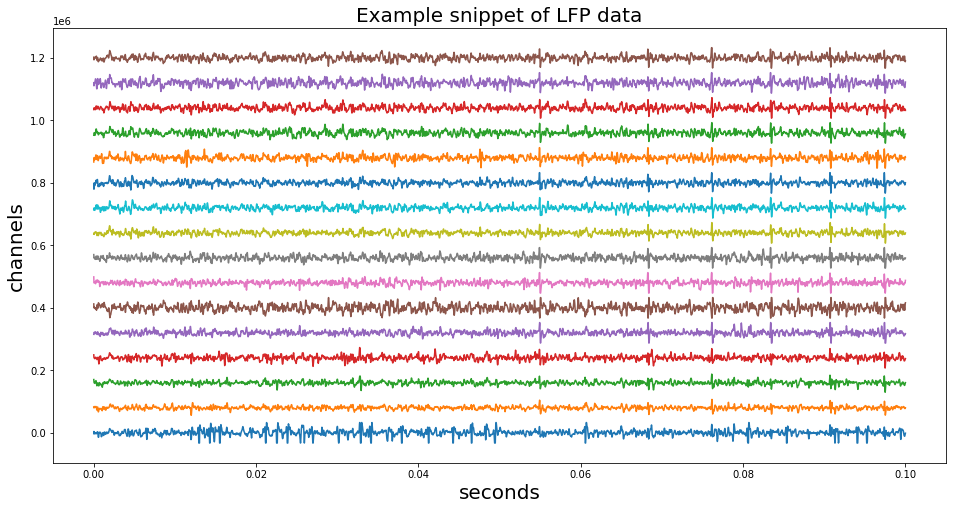

In [40]:
plot_data_snippet(arr, start_idx=0, end_idx=4800, Fs=48000, Nch = 16)

In [41]:
# Do we get the same arrays with the mmap method from binconverter, and the axonarawio method using memmap?

print(type(arr))
print(type(raw_sigs))

np.array_equal(arr[0:16, :], raw_sigs)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


True

## Comparing methods for reading continuous raw data

I originally tried to speed up Geoffrey's code, but simply using np.memmap seems to be a good solution. We can memory map the entire .bin file, but then dynamically read out the channels and samples we actually want in `_get_analogsignal_chunk()`

In [42]:
# Create memory map

def memory_map(filename, access=mmap.ACCESS_READ):
    size = os.path.getsize(filename)
    print(size)
    file_descriptor = os.open(filename, os.O_RDONLY) 
    return mmap.mmap(file_descriptor, size, access=access)

mmap_obj = memory_map(bin_file)

4147243200


#### Method 1 (mmap - from BinConverter package)
Using python's mmap library, load all channels in one go (but without header and footer), then remap and select channel indeces of interest. This loads a lot of data into memory, and it is difficult to avoid this with this method (though probably possible to improve). np.memmap is a better option - see below.

In [44]:
i_end = 48000
i_start = 0

num_sel_packets = (i_end-i_start) // 3

In [45]:
#%%timeit

# Read all channels at once
data = np.ndarray(shape=(num_sel_packets,), 
                  dtype=(np.int16, (bytes_data//2)),
                  buffer=mmap_obj[i_start:bytes_packet*i_end],
                  offset=bytes_head, 
                  strides=(bytes_packet,)).reshape((-1, 1)).flatten()

arr = samples_to_array(data, channels = [])  # remaps channels and converts vector to array

In [46]:
arr.shape

(64, 48000)

#### Method 2 (np.memmap)
Create numpy.memmap object for the whole .bin file (including header, footer, empty channels...),
and then dynamically only read data into memory as needed (in `_get_analogsignal_chunk()`)

In [47]:

global_header_size = 0
raw_data = np.memmap(bin_file, dtype='int16', mode='r', offset=global_header_size)

print('Size of raw_data:', len(raw_data))
print('Peak at raw_data:', raw_data[16:26])
print('Type of raw_data:', type(raw_data))

Size of raw_data: 2073621600
Peak at raw_data: [ -4384  -6024  -4552 -13192  -7572  -5500    798   2378   1886  -7572]
Type of raw_data: <class 'numpy.memmap'>


In [48]:
# Can we simply select data by indexing? Then we can dynamically create the 
# indeces of the channels and sampled we are interested in!

test_indeces = [2,3,5,1,6,7,139,1284,231938,392318,2182,3824294,200000000]

raw_data[test_indeces]

array([ 1165,     0,     1, 12629,     0,     0,     0,     0,     0,
           0, -3160,     0,     0], dtype=int16)

In [49]:
"""
Return raw (continuous) signals as 2d numpy array (chan x time).
Note that block_index and seg_index are always 1 (regardless of input).

The raw data is in a single vector np.memmap with the following structure:

Each byte packet (432 bytes) has a header (32 bytes), a footer (16 bytes)
and three samples of 2 bytes each for 64 channels (384 bytes), which are 
jumbled up in a strange order. Each channel is remapped to a certain position
(see get_remap_chan), and a channel's samples are allcoated as follows
(example for channel 7):

sample 1: 32b (head) + 2*38b (remappedID) or 2*38b + 1b (second byte of sample)
sample 2: 32b (head) + 128 (all channels 1st entry) + 2*38b (remappedID) or ...
sample 3: 32b (head) + 128*2 (all channels 1st and 2nd entry) + ...
"""
channel_indexes = None
num_channels = 16
i_stop = 48000
i_start = 0

if channel_indexes is None:
    channel_indexes = [i+1 for i in range(num_channels)]

# Each packet has three samples for each channel
# Note this means you can only read out multiples of 3
num_samples = (i_stop-i_start)

# Read one channel at a time
raw_signals = np.ndarray(shape=(num_samples, len(channel_indexes)))
offset = bytes_head // 2


for i, ch_idx in enumerate(channel_indexes):
    chan_offset = get_remap_chan(ch_idx)

    # Create id vector to read data for this channel
    # Note we only consider multiples of three for now
    cur_ids = []
    for isamp in range(num_samples//3):

        cur_ids.extend([isamp*(bytes_packet//2) + offset + chan_offset, 
                        isamp*(bytes_packet//2) + offset + 64 + chan_offset,
                        isamp*(bytes_packet//2) + offset + 64*2 + chan_offset])

    raw_signals[:,i] = raw_data[cur_ids]  

In [50]:
raw_signals.T[0][0:10]

array([ 3682., -3870.,     0.,  3132.,  -124., -1788., -2422., -2052.,
       -1046.,  -102.])

In [51]:
arr[0][0:10]

array([ 3682., -3870.,     0.,  3132.,  -124., -1788., -2422., -2052.,
       -1046.,  -102.])

### Optimize timing of reading continous data (`get_analogsignal_chunk`)
Idexing the data from np.memmap object is actually quite fast. But creating the indeces takes a long time.

Solution: Create indeces in `_parse_header()` for a single channel and adjust as needed for other channels by adding the differences in channel_offset.

In [57]:
%%timeit

i_start = 0
i_stop = 1000000
num_samples = (i_stop-i_start)

cur_ids = []
for isamp in range(num_samples//3):

    cur_ids.extend([isamp*(bytes_packet//2) + offset + chan_offset, 
                    isamp*(bytes_packet//2) + offset + 64 + chan_offset,
                    isamp*(bytes_packet//2) + offset + 64*2 + chan_offset])

354 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%%timeit

np.array(cur_ids)

1.91 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%%timeit

i_start = 0
i_stop = 1000000
num_samples = (i_stop-i_start)
offset = np.int32(16)
chan_offset = np.int32(31)
packet_size = np.int32(432//2)

cur_ids = []
for isamp in range(np.int32(num_samples//3)):

    cur_ids.extend([isamp*packet_size + offset + chan_offset, 
                    isamp*packet_size + offset + 64 + chan_offset,
                    isamp*packet_size + offset + 64*2 + chan_offset])

2.62 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
i_start = 0
i_stop = 1000000
num_samples = (i_stop-i_start)
offset = np.int32(16)
chan_offset = np.int32(31)
packet_size = np.int32(432//2)

cur_ids = []
for isamp in range(np.int32(num_samples//3)):

    cur_ids.extend([isamp*packet_size + offset + chan_offset, 
                    isamp*packet_size + offset + 64 + chan_offset,
                    isamp*packet_size + offset + 64*2 + chan_offset])

In [60]:
cur_id_arr = np.array(cur_ids)

In [52]:
%%timeit

i_start = 0
i_stop = 1000000
num_samples = (i_stop-i_start)
offset = np.int32(16)
chan_offset = np.int32(31)
packet_size = np.int32(432//2)

cur_ids = np.empty((num_samples,))
for isamp in range(0, np.int32(num_samples-1), 3):

    cur_ids[isamp:isamp+3] = np.array([isamp*packet_size + offset + chan_offset, 
                    isamp*packet_size + offset + 64 + chan_offset,
                    isamp*packet_size + offset + 64*2 + chan_offset])

3.41 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%%timeit

cur_id_arr + 32

2.01 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
len(cur_ids)

999999

In [55]:
%%timeit

raw_data[cur_ids]  

62.1 ms ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
import sys
print(sys.getsizeof(cur_ids))  ## save 1 list of indeces, which can be adjusted based on channel to speed things up. Use int32

# Largest signed integer with 32 bits (I guess I could use unsigned?)
2**31 - 1  # the 4th Mersenne prime ;)

8019504


2147483647

In [62]:
num_samples

1000000

In [39]:
# Maybe we can use np.linspace (which is a bit faster) to create 3 linearly spaced arrays for samples 1,2 and 3 and then
# combine them

sample1 = np.linspace(bytes_head//2, num_packets*216, num_packets, dtype=int)
sample2 = sample1 + 64
sample3 = sample2 + 64

cur_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
cur_ids[0::3] = sample1
cur_ids[1::3] = sample2
cur_ids[2::3] = sample3

In [40]:
print(sample1[0:10])
print(sample2[0:10])
print(sample3[0:10])
print(' ')
print(cur_ids[0:10])

[  16  232  448  664  880 1096 1312 1528 1744 1960]
[  80  296  512  728  944 1160 1376 1592 1808 2024]
[ 144  360  576  792 1008 1224 1440 1656 1872 2088]
 
[ 16  80 144 232 296 360 448 512 576 664]


In [61]:
%%timeit

sample1 = np.linspace(bytes_head//2, num_packets*432, num_packets, dtype=int)
sample2 = sample1 + 64
sample3 = sample2 + 64

cur_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
cur_ids[0::3] = sample1
cur_ids[1::3] = sample2
cur_ids[2::3] = sample3

1.06 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Okay, so using linspace can speed things up quite a lot. I can call this in `_parse_header` and create all other needed index vectors in `_get_analogsignal_chunk`.

Adding the channel offset should be straightforward (simply add chan_offset). And taking into account i_start and i_stop is also straightforward. Since the index vector contains one index for each sample, we simply slice with index_vec[i_start:i_stop].

Now I need to see if I can get the same output with it!

In [64]:
# Create base index vector for _raw_signals
sample1 = np.linspace(bytes_head//2, num_packets*(bytes_packet//2), 
                      num_packets, dtype=int)
sample2 = sample1 + 64
sample3 = sample2 + 64

sig_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
sig_ids[0::3] = sample1
sig_ids[1::3] = sample2
sig_ids[2::3] = sample3

Do I get the same result if I load in 8000 samples starting from 0 and use plot_data_snippet to show 4000 to 8000 vs when I read in data from 4000 to 8000 and plot everything?

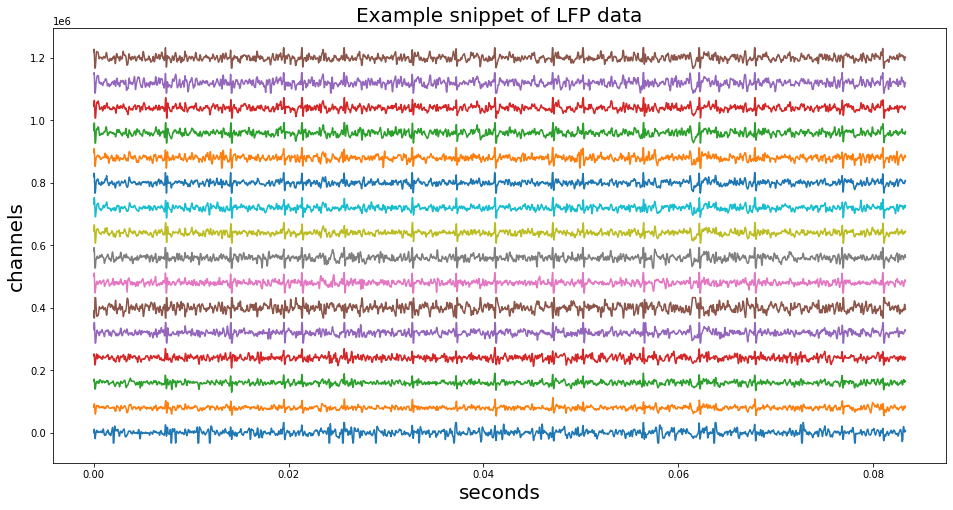

In [65]:
# 1. Load All data, then plot 4000 to 8000 samples

num_channels = 16
channel_indexes = None
i_stop = 8000
i_start = 0

if channel_indexes is None:
    channel_indexes = [i+1 for i in range(num_channels)]

# Each packet has three samples for each channel
# Note this means you can only read out multiples of 3
num_samples = (i_stop-i_start)
user_offset = (i_start//3) * (bytes_packet//2) + 64*(i_start%3)

# Read one channel at a time
raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

for i, ch_idx in enumerate(channel_indexes):

    chan_offset = get_remap_chan(ch_idx)
    raw_signals[i,:] = r._raw_signals[sig_ids[0:num_samples] + \
                                      chan_offset+user_offset]

raw_1 = raw_signals
plot_data_snippet(raw_signals, start_idx=4000, end_idx=num_samples, Fs=48000, Nch = 16)

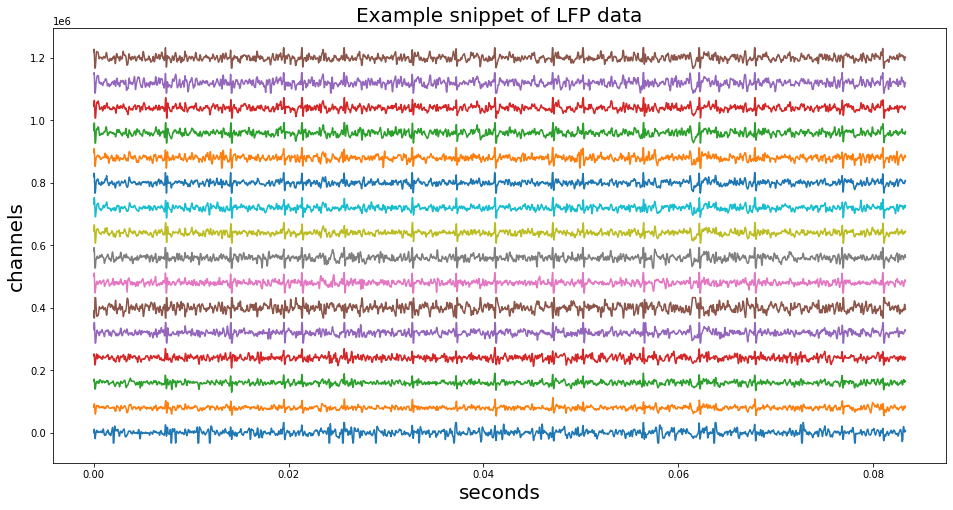

In [66]:
# 2. Load data from 4000 to 8000 samples and plot all

channel_indexes = None
i_stop = 8000
i_start = 4000

if channel_indexes is None:
    channel_indexes = [i+1 for i in range(num_channels)]

# Each packet has three samples for each channel
# Note this means you can only read out multiples of 3
num_samples = (i_stop-i_start)

# Read one channel at a time
raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

for i, ch_idx in enumerate(channel_indexes):

    chan_offset = get_remap_chan(ch_idx)
    raw_signals[i,:] = r._raw_signals[sig_ids[i_start:i_stop] + \
                                      chan_offset]

raw_2 = raw_signals
plot_data_snippet(raw_signals, start_idx=0, end_idx=num_samples, Fs=48000, Nch = 16)

In [106]:
print(raw_1.shape)
print(raw_2.shape)

(16, 8000)
(16, 4000)


In [107]:
np.array_equal(raw_1[:,4000::], raw_2)

True

In [108]:
print('The total number of samples in this dataset is: ', num_packets*3)

The total number of samples in this dataset is:  28800300


In [68]:
# Why does the code below crash for 28800300 samples? Should I not have 28800300 samples in total?

# 28800000 still works,
# 28800200 still works,
# 28800297 still works
# 28800298 crashes!

# Does this have to do with python indexing from 0 and there being 3 samples per packet? ... 
# But what's going on exactly?

# Well, something like this would have "num_packets" lists
# [0, 1, 2], [3, 4, 5], ..., [28800297, 28800298, 28800299]

In [69]:
# Currently, reading a single channel takes ~1.25s
# Reading 16 channels takes ~36s

# For reference, reading the complete bin file took 2:30min (but that's wall time, should I pay attention to sys time?)

In [81]:
%%timeit

channel_indexes = [1, 2]
i_stop = 28800297
i_start = 0

if channel_indexes is None:
    channel_indexes = [i+1 for i in range(num_channels)]

# Each packet has three samples for each channel
# Note this means you can only read out multiples of 3
num_samples = (i_stop-i_start)
user_offset = i_start*(bytes_packet//2)

# Read one channel at a time
raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

# This is in principle paralellizable!
for i, ch_idx in enumerate(channel_indexes):

    chan_offset = get_remap_chan(ch_idx)
    raw_signals[i,:] = r._raw_signals[sig_ids[0:num_samples] + \
                                      chan_offset+user_offset]

3.24 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%%timeit

raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=0, i_stop=28800297, channel_indexes=None)

#plot_data_snippet(raw_sigs, start_idx=0, end_idx=4800, Fs=48000, Nch=16)

35.5 s ± 7.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Running these things without %%timeit actually makes them take way longer (much larger wall time), why?

In [ ]:
# Can we create a memory map for sample1, sample2, sample3 (for a given channel), and then combine it? 
# 

In [ ]:
raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=0, i_stop=28800297, stream_index=0, channel_indexes=None)

In [88]:
raw_sigs.shape

(16, 28800297)

In [ ]:
plot_data_snippet(raw_sigs, start_idx=0, end_idx=4800, Fs=48000, Nch=16)

In [89]:
sig_ids.shape

(28800300,)

In [91]:
print(sys.getsizeof(sig_ids))
print(sys.getsizeof(raw_sigs))

230402504
3686438136


For comparison, how long does it take to just load the whole bin file into memory?

It takes 2min 32s.. so maybe my implementation is fast enough.

In [7]:
%%timeit

with open(bin_file, 'rb') as f:
    content = f.read()

2min 35s ± 1.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
print(type(sig_ids[0]))
print(type(raw_signals[0,0]))

<class 'numpy.int64'>
<class 'numpy.float64'>


### Create index vector for memmap on the fly (in get_analogsignal_chunk)

`_get_analogsignal_chunk` will take slightly longer to run, but this will only really be noticeable when the user wants to read in a lot of data at once. In which case the loading is anyway slow. On the other hand with can save quite some time and memory when we do not create this vector unnecessarily for the whole length of the dataset, irrespective of what the user actually wants to read out. 

In [61]:
# 2. Load data from 4000 to 8000 samples and plot all

channel_indexes = None
i_start = 4000
i_stop = 8000

if channel_indexes is None:
    channel_indexes = [i+1 for i in range(num_channels)]

# Each packet has three samples for each channel
# Note this means you can only read out multiples of 3
num_samples = (i_stop-i_start)

# Read one channel at a time
raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

for i, ch_idx in enumerate(channel_indexes):

    chan_offset = get_remap_chan(ch_idx)
    raw_signals[i,:] = r._raw_signals[sig_ids[i_start:i_stop] + \
                                      chan_offset]

raw_2 = raw_signals
plot_data_snippet(raw_signals, start_idx=0, end_idx=num_samples, Fs=48000, Nch = 16)

ValueError: could not broadcast input array from shape (0,) into shape (4000,)

In [72]:
# Create base index vector for _raw_signals
sample1 = np.linspace(bytes_head//2, num_packets*(bytes_packet//2), 
                      num_packets, dtype=int)
sample2 = sample1 + 64
sample3 = sample2 + 64

sig_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
sig_ids[0::3] = sample1
sig_ids[1::3] = sample2
sig_ids[2::3] = sample3

In [68]:
i_start = 0
i_stop = 4000

In [75]:
num_packets_oi

1334

In [86]:
test = sig_ids[i_start:i_stop]
print(test[0:10])

[ 16  80 144 232 296 360 448 512 576 664]


In [97]:
print(sig_ids[15:29])
print(test[15:29])

print(sig_ids[89:99])
print(test[89:99])

[1096 1160 1224 1312 1376 1440 1529 1593 1657 1745 1809 1873 1961 2025]
[1096 1160 1224 1312 1376 1440 1528 1592 1656 1744 1808 1872 1960 2024]
[6412 6500 6564 6628 6716 6780 6844 6932 6996 7060]
[6408 6496 6560 6624 6712 6776 6840 6928 6992 7056]


In [220]:
def get_signal1(i_start=0, i_stop=2000, channel_indexes=None):

    if channel_indexes is None:
        channel_indexes = [i+1 for i in range(num_channels)]

    num_samples = (i_stop-i_start)

    # Create base index vector for _raw_signals for time period of interest
    num_packets_oi = (num_samples+2) // 3
    
    sample1 = np.arange(num_packets, dtype=np.uint32)*(bytes_packet//2) + \
                  bytes_head//2
    sample2 = sample1 + 64
    sample3 = sample2 + 64

    sig_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
    sig_ids[0::3] = sample1
    sig_ids[1::3] = sample2
    sig_ids[2::3] = sample3
    print(sig_ids[i_start:i_stop])

    # Read one channel at a time
    raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

    for i, ch_idx in enumerate(channel_indexes):

        chan_offset = get_remap_chan(ch_idx)
        raw_signals[i,:] = r._raw_signals[sig_ids[i_start:i_stop] + chan_offset]
        
    plot_data_snippet(raw_signals, start_idx=0, end_idx=num_samples, Fs=48000, Nch = 16)

    return raw_signals

In [221]:
def get_signal2(i_start=0, i_stop=2000, channel_indexes=None):

    if channel_indexes is None:
        channel_indexes = [i+1 for i in range(num_channels)]

    num_samples = (i_stop-i_start)

    # Create base index vector for _raw_signals for time period of interest
    num_packets_oi = (num_samples+2) // 3
    offset = i_start//3 * (bytes_packet//2) 
    rem = (i_start % 3)

    sample1 = np.arange(num_packets_oi+1, dtype=np.uint32)*(bytes_packet//2) + \
                  bytes_head//2 + offset
    sample2 = sample1 + 64
    sample3 = sample2 + 64

    sig_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
    sig_ids[0::3] = sample1
    sig_ids[1::3] = sample2
    sig_ids[2::3] = sample3
    sig_ids = sig_ids[rem:(rem+num_samples)]
    print(sig_ids)

    # Read one channel at a time
    raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

    for i, ch_idx in enumerate(channel_indexes):

        chan_offset = get_remap_chan(ch_idx)
        raw_signals[i,:] = r._raw_signals[sig_ids + chan_offset]

    plot_data_snippet(raw_signals, start_idx=0, end_idx=num_samples, Fs=48000, Nch = 16)

    return raw_signals

[2072894560 2072894624 2072894688 ... 2073038328 2073038416 2073038480]


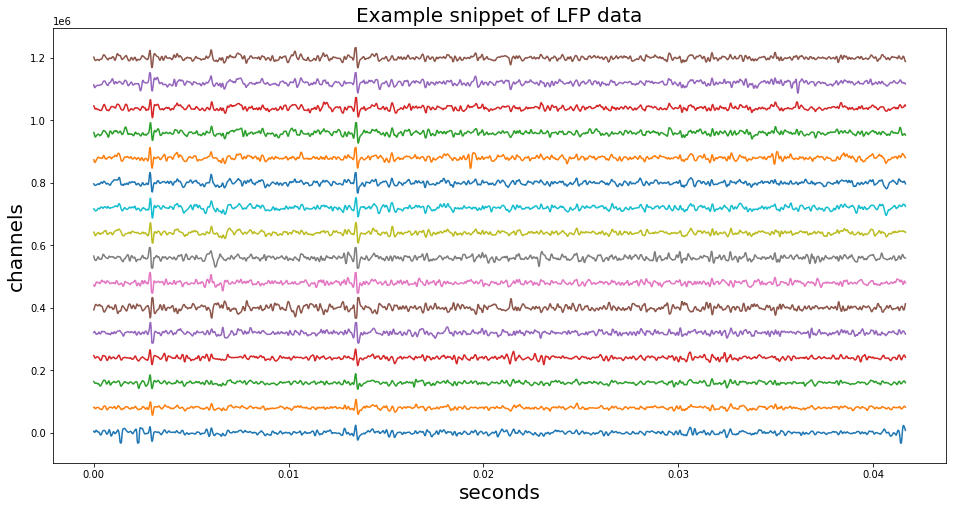

[2072894560 2072894624 2072894688 ... 2073038328 2073038416 2073038480]


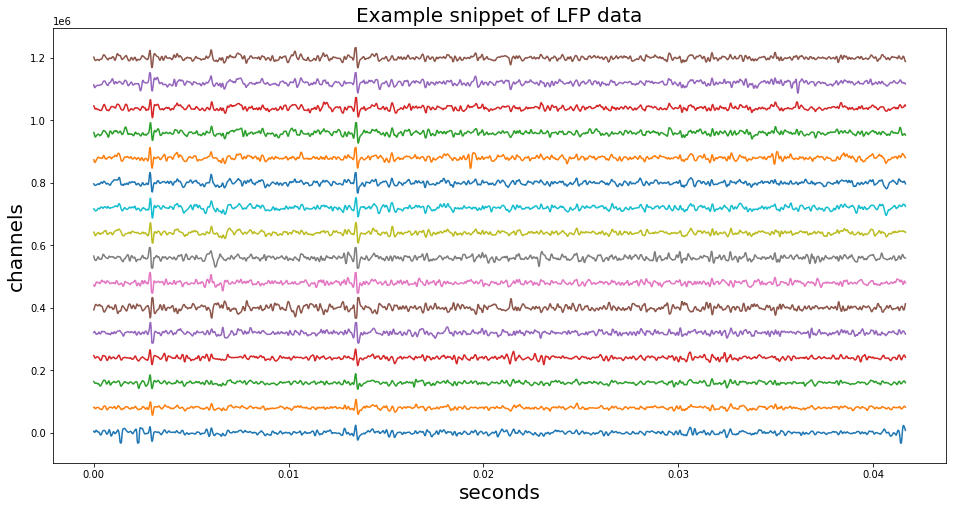

In [230]:
t_start = 28790202
t_stop = t_start + 2000

raw_sigs1 = get_signal1(i_start=t_start, i_stop=t_stop)
raw_sigs2 = get_signal2(i_start=t_start, i_stop=t_stop)

assert np.array_equal(raw_sigs1, raw_sigs2)

Note that in my previous implementation using np.linspace, there can easily be issues with non 216-stepsizes from sample to sample. Using np.arange fixes this nicely!

In [ ]:
# eof